# Netflix Insights - Explorative Data Analysis

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

In [183]:
netflix = pd.read_csv("data/netflix_titles.csv")
netflix.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


In [184]:
len(netflix)    #Dataset length

8807

#### What is the total number of movies and TV shows available on Netflix for each year?

In [185]:
total_num = netflix.copy()

#change 'date added' column from str to datetime
total_num["date_added"] = pd.to_datetime(total_num["date_added"], errors='coerce')
total_num.loc[:, "year_added"] = total_num["date_added"].dt.year.astype('Int64')

#seperated movies and tvshows 
movies_count = total_num.loc[total_num["type"] == "Movie"]
tvshows_count = total_num.loc[total_num["type"] == "TV Show"]

In [187]:
#How many movies and tv shows were added each year
combined_count = total_num.pivot_table(values="title", index="year_added", columns="type", aggfunc="count", fill_value=0)

In [188]:
combined_count

type,Movie,TV Show
year_added,,
2008,1,1
2009,2,0
2010,1,0
2011,13,0
2012,3,0
2013,6,4
2014,19,4
2015,56,17
2016,253,165


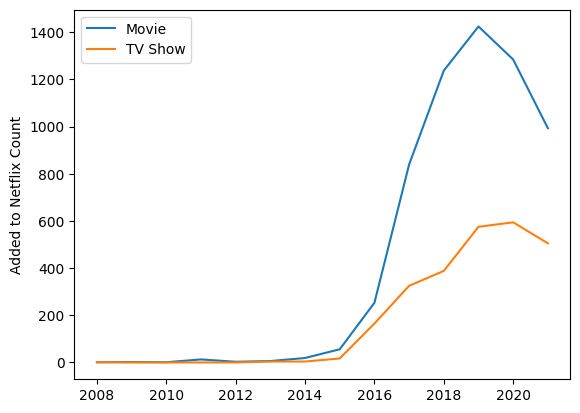

In [192]:
combined_count.plot(kind="line")
plt.ylabel("Added to Netflix Count")
plt.xlabel("")
plt.legend()
plt.show()

#### Which genres are the most popular on Netflix?

In [228]:
popular_genres = total_num.copy()
popular_genres.loc[:,"listed_in"].value_counts()

popular_genres["listed_in"] = popular_genres["listed_in"].apply(lambda x: x.split(", ")) #popular_genres.explode("listed_in")

In [229]:
popular_genres = popular_genres.explode("listed_in")

In [245]:
genre_counts = popular_genres["listed_in"].value_counts().head(10).sort_values(ascending=True)
genre_counts

listed_in
Romantic Movies              616
Children & Family Movies     641
Independent Movies           756
TV Dramas                    763
Action & Adventure           859
Documentaries                869
International TV Shows      1351
Comedies                    1674
Dramas                      2427
International Movies        2752
Name: count, dtype: int64

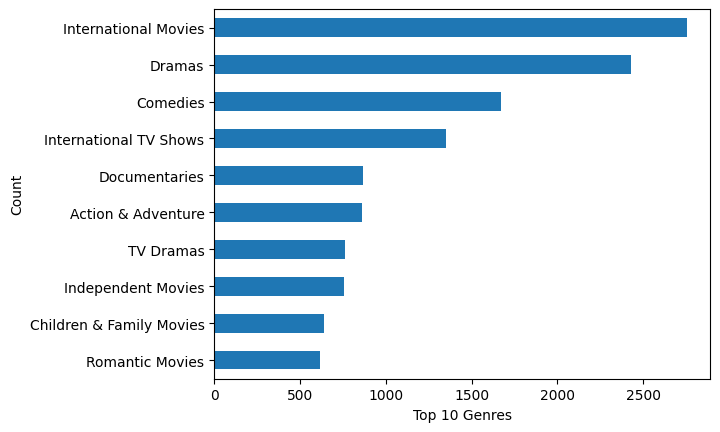

In [246]:
genre_counts.plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Top 10 Genres")
plt.show()